In [ ]:
import kagglehub
sartajbhuvaji_brain_tumor_classification_mri_path = kagglehub.dataset_download('sartajbhuvaji/brain-tumor-classification-mri')
aryashah2k_breast_ultrasound_images_dataset_path = kagglehub.dataset_download('aryashah2k/breast-ultrasound-images-dataset')

print('Data source import complete.')

Data source import complete.


In [ ]:
import tensorflow as tf


class AttrDict(dict):
    __setattr__ = dict.__setitem__
    __getattr__ = dict.__getitem__


def plot_grid_ds(ds, model=None, size=(3, 3), figsize=(10, 10)):
    from copy import copy
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import ImageGrid

    n = size[0] * size[1]
    ds_ = copy(ds)

    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(
        fig,
        111,
        nrows_ncols=size,
        axes_pad=0.3,
    )
    for X_batch, y_batch in ds_.unbatch().shuffle(n).batch(n).take(1):
        y_hat_batch = model.predict(X_batch).argmax(axis=-1) if model else y_batch
        for X, y, y_hat, ax in zip(X_batch, y_batch, y_hat_batch, grid):
            title = (
                f"{ds.class_names[y]} (true) - {ds.class_names[y_hat]} (pred)"
                if model
                else f"{ds.class_names[y]}"
            )
            ax.set_title(title)
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)
            ax.imshow(X / 255, cmap="gray")
    return grid


class BalancedSparseCategoricalAccuracy(tf.keras.metrics.SparseCategoricalAccuracy):
    def __init__(self, name="balanced_sparse_categorical_accuracy", dtype=None):
        super().__init__(name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_flat = y_true
        if y_true.shape.ndims == y_pred.shape.ndims:
            y_flat = tf.squeeze(y_flat, axis=[-1])
        y_true_int = tf.cast(y_flat, tf.int32)

        cls_counts = tf.math.bincount(y_true_int)
        cls_counts = tf.math.reciprocal_no_nan(tf.cast(cls_counts, self.dtype))
        weight = tf.gather(cls_counts, y_true_int)
        return super().update_state(y_true, y_pred, sample_weight=weight)

In [ ]:
import tensorflow as tf



class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


class ViTClassfier(tf.keras.models.Model):
    CONFIG = {
        "patch_size": 4,
        "embedding_dim": 32,
        "n_heads": 2,
        "n_transformers": 1,
        "transformer_units": [64, 32],
        "transformer_dropout": 0.1,
        "mlp_units": [2048, 1024],
        "mlp_dropout": 0.1,
    }

    def __init__(self, input_shape, n_classes, config={}):
        super(ViTClassfier, self).__init__()

        self._config = AttrDict(
            **{
                **self.CONFIG,
                **config,
                "input_shape": input_shape,
                "n_classes": n_classes,
            }
        )
        self._construct_model()

    def call(self, x):
        return self._model(x)

    def _construct_model(self):
        config = self._config

        num_patches = (config["input_shape"][0] // config["patch_size"]) ** 2

        inputs = tf.keras.layers.Input(shape=config["input_shape"])

        patches = Patches(config["patch_size"])(inputs)
        # Encode patches.
        encoded_patches = PatchEncoder(num_patches, config["embedding_dim"])(patches)

        # Create multiple layers of the Transformer block.
        for _ in range(config["n_transformers"]):
            # Layer normalization 1.
            x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
            # Create a multi-head attention layer.
            attention_output = tf.keras.layers.MultiHeadAttention(
                num_heads=config["n_heads"], key_dim=config["embedding_dim"], dropout=0.1
            )(x1, x1)
            # Skip connection 1.
            x2 = tf.keras.layers.Add()([attention_output, encoded_patches])
            # Layer normalization 2.
            x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
            # MLP.
            for units in config["transformer_units"]:
                x3 = tf.keras.layers.Dense(units, activation=tf.nn.gelu)(x3)
                x3 = tf.keras.layers.Dropout(config["transformer_dropout"])(x3)

            # Skip connection 2.
            encoded_patches = tf.keras.layers.Add()([x3, x2])

        # Create a [batch_size, projection_dim] tensor.
        features = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        features = tf.keras.layers.Flatten()(features)
        features = tf.keras.layers.Dropout(0.5)(features)
        # Add MLP.
        for units in config["mlp_units"]:
            features = tf.keras.layers.Dense(units, activation=tf.nn.gelu)(features)
            features = tf.keras.layers.Dropout(config["mlp_dropout"])(features)
        # Classify outputs.
        logits = tf.keras.layers.Dense(config["n_classes"])(features)
        # Create the Keras model.
        self._model = tf.keras.models.Model(inputs=inputs, outputs=logits)

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


path = Path("/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT")
img_as_jpg = list(path.glob(r"*/*.png"))

# Counts the number of each categories in the dataset
file_count = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],img_as_jpg))
benign = file_count.count('benign')
malignant = file_count.count('malignant')
normal = file_count.count('normal')

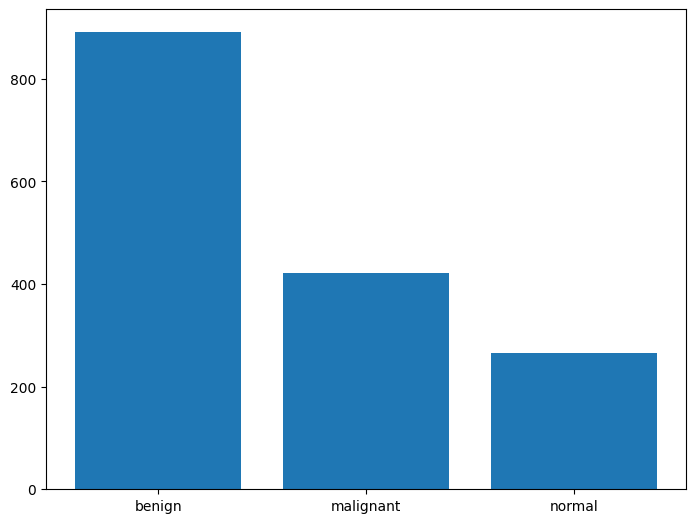

In [ ]:
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
labels = ['benign','malignant', 'normal']
count_train = [benign,malignant,normal]
ax.bar(labels, count_train)
plt.show()

In [ ]:
train = pd.concat([pd.Series(img_as_jpg,name="image").apply(str),pd.Series(file_count, name="type")],axis=1)
train = train.sample(frac=1).reset_index(drop=True)
print(np.shape(train))

(1578, 2)


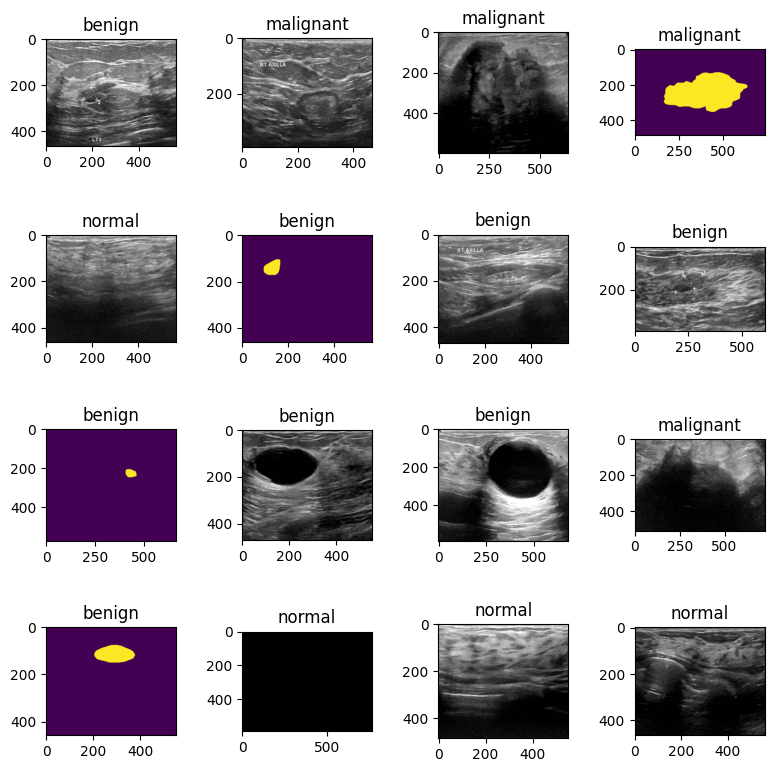

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.tight_layout()
counter = 0
for ax in axes.reshape(-1):
    ax.imshow(plt.imread(train["image"][counter]))
    ax.set_title(train["type"][counter])
    plt.rcParams["axes.grid"] = False
    counter = counter+1

In [ ]:
hparams = AttrDict(
    image_size=(128, 128, 3),
    n_classes=3,
    batch_size=64,
)

ds = tf.keras.preprocessing.image_dataset_from_directory("/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT", image_size=hparams.image_size[:-1], batch_size=hparams.batch_size)
train_split = round(0.8 * ds.cardinality().numpy())
train_ds = ds.take(train_split); train_ds.class_names = ds.class_names
validation_ds = ds.skip(train_split); validation_ds.class_names = ds.class_names

Found 1578 files belonging to 3 classes.


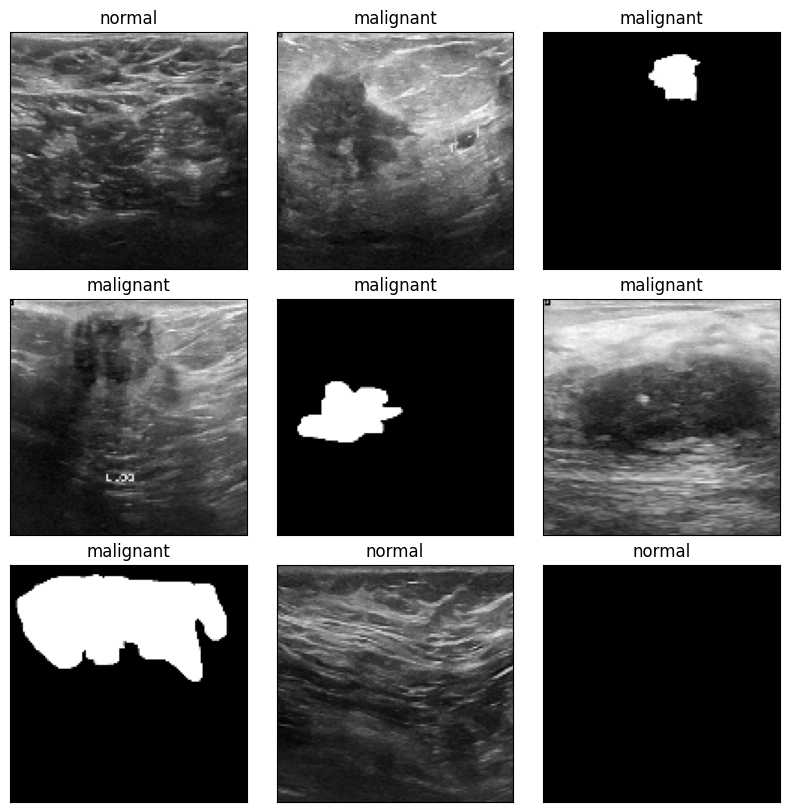

In [ ]:
_ = plot_grid_ds(train_ds)

In [ ]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = ViTClassfier(hparams.image_size, hparams.n_classes)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy", BalancedSparseCategoricalAccuracy()]
    )

In [ ]:
import time

start = time.time()


model.fit(train_ds, epochs=40, validation_data=validation_ds)
end = time.time()

Epoch 1/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 833ms/step - accuracy: 0.3767 - balanced_sparse_categorical_accuracy: 0.3483 - loss: 62.8558 - val_accuracy: 0.5705 - val_balanced_sparse_categorical_accuracy: 0.4021 - val_loss: 3.7437
Epoch 2/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 730ms/step - accuracy: 0.4355 - balanced_sparse_categorical_accuracy: 0.4015 - loss: 4.3916 - val_accuracy: 0.5101 - val_balanced_sparse_categorical_accuracy: 0.3804 - val_loss: 2.5391
Epoch 3/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 791ms/step - accuracy: 0.5081 - balanced_sparse_categorical_accuracy: 0.3964 - loss: 2.0951 - val_accuracy: 0.6946 - val_balanced_sparse_categorical_accuracy: 0.6737 - val_loss: 0.8218
Epoch 4/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 709ms/step - accuracy: 0.6394 - balanced_sparse_categorical_accuracy: 0.5749 - loss: 0.8628 - val_accuracy: 0.6275 - val_balanced_sparse_categorical_accuracy: 0.5023 - val_loss: 0.7726
Epoch 5/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 715ms/step - accuracy: 0.6935 - balanced_sparse_c

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


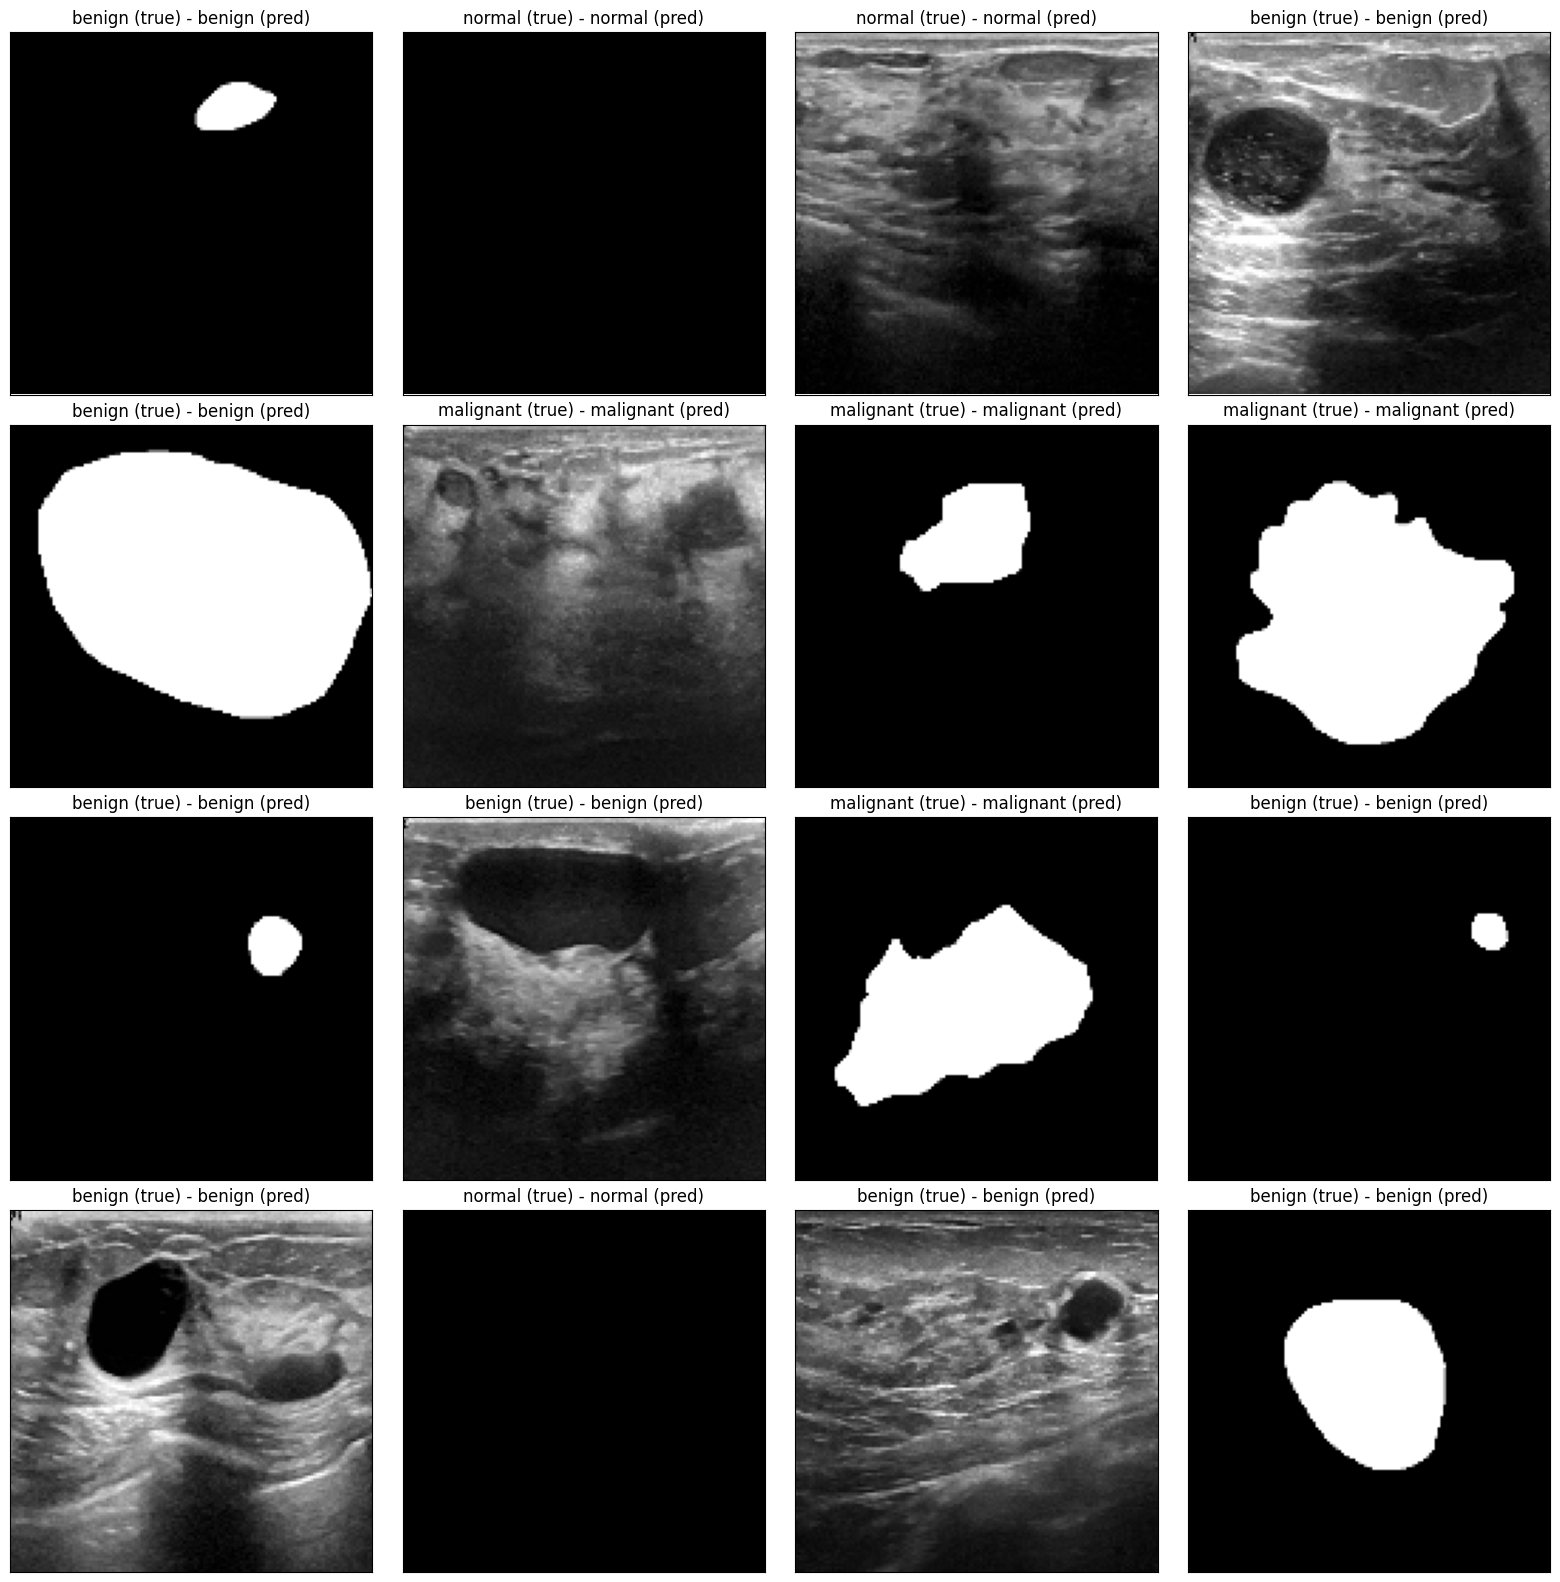

In [ ]:
_ = plot_grid_ds(validation_ds, size=(4, 4), model=model, figsize= (20,20))

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

X, y_true = list(zip(*[(X, y) for (X, y) in validation_ds.unbatch().as_numpy_iterator()]))
y_hat = model.predict_on_batch(np.array(X)).argmax(axis=-1)
mat = confusion_matrix(y_true, y_hat)
mat

array([[158,   0,   0],
       [  5,  82,   0],
       [  0,   0,  53]])

In [ ]:
from sklearn.metrics import balanced_accuracy_score

acc = balanced_accuracy_score(y_true, y_hat)
print(f"Final accuracy on validation set : {acc:.3f}")

Final accuracy on validation set : 0.981


In [ ]:
# Import necessary libraries
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import io

# Create UI components
patient_name = widgets.Text(description="Patient Name:")
patient_id = widgets.Text(description="Patient ID:")
patient_age = widgets.IntSlider(description="Patient Age:", min=1, max=100, value=50)
image_upload = widgets.FileUpload(accept='.jpg,.jpeg,.png', multiple=False)
classify_button = widgets.Button(description="Classify")
output_area = widgets.Output()

# Classification function
def on_classify_click(b):
    with output_area:
        clear_output()

        if not image_upload.value:
            print("⚠️ Please upload an ultrasound image")
            return

        # Process uploaded image
        uploaded_file = next(iter(image_upload.value.values()))
        img = Image.open(io.BytesIO(uploaded_file['content'])).convert('RGB')
        img_resized = img.resize(hparams.image_size[:2])

        # Prepare for model input
        img_array = np.expand_dims(np.array(img_resized), axis=0)

        # Predict
        logits = model.predict(img_array)
        probs = tf.nn.softmax(logits, axis=-1).numpy()[0]
        pred_class = np.argmax(logits, axis=-1)[0]
        confidence = probs[pred_class]
        class_name = train_ds.class_names[pred_class]

        # Display results
        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.imshow(img_resized)
        plt.title(f"Resized to {hparams.image_size[:2]}")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"🔍 Classification Result: {class_name.upper()}")
        print(f"✅ Confidence: {confidence*100:.2f}%")
        print(f"📋 Patient: {patient_name.value} | ID: {patient_id.value} | Age: {patient_age.value}")

# Link button to function
classify_button.on_click(on_classify_click)

# Display UI
input_panel = widgets.VBox([
    widgets.HBox([patient_name, patient_id]),
    patient_age,
    image_upload,
    classify_button
])

display(input_panel, output_area)